In [1]:
#!mim download mmdet --config faster_rcnn_r50_fpn_1x_coco --dest .

In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv

from ast import literal_eval
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.executable

'/home/vincent/miniconda3/envs/openmmlab/bin/python'

# Tutorial
## High Level API

In [2]:
# Specify the path to model config and checkpoint file
config_file = 'configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# test a single image and show the results
img = 'demo.jpg'  # or img = mmcv.imread(img), which will only load it once
result = inference_detector(model, img)

# test a video and show the results
# video = mmcv.VideoReader('video.mp4')
# for frame in video:
#     result = inference_detector(model, frame)
#     model.show_result(frame, result, wait_time=1)

load checkpoint from local path: checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


/home/vincent/miniconda3/envs/openmmlab/lib/python3.7/site-packages/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


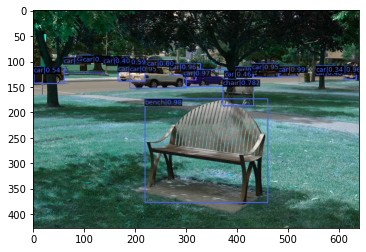

In [3]:
# visualize the results in a new window
plt.imshow(model.show_result(img, result))

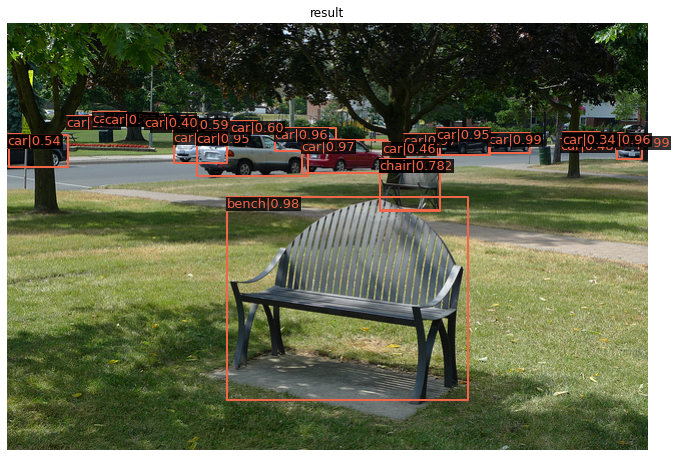

In [4]:
show_result_pyplot(model, img, result)

In [5]:
# or save the visualization results to image files
model.show_result(img, result, out_file='result.jpg')

# Create COCO Dataset 

In [6]:
TRAIN_PATH = '/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/train_images'
df = pd.read_csv('/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/train.csv')
n_with_annotations = (df['annotations'] != '[]').sum()

df['annotations'] = df['annotations'].apply(literal_eval)
df['path'] = df.apply(lambda row: f"{TRAIN_PATH}/video_{row['video_id']}/{row['video_frame']}.jpg", axis = 1)

df.tail()

video_id  sequence  video_frame  sequence_frame image_id annotations  \
23496         2     29859        10755            2983  2-10755          []   
23497         2     29859        10756            2984  2-10756          []   
23498         2     29859        10757            2985  2-10757          []   
23499         2     29859        10758            2986  2-10758          []   
23500         2     29859        10759            2987  2-10759          []   

                                                    path  
23496  /home/vincent/Kaggle/data/tensorflow-great-bar...  
23497  /home/vincent/Kaggle/data/tensorflow-great-bar...  
23498  /home/vincent/Kaggle/data/tensorflow-great-bar...  
23499  /home/vincent/Kaggle/data/tensorflow-great-bar...  
23500  /home/vincent/Kaggle/data/tensorflow-great-bar...

## CV Split

In [7]:

df['has_annotations'] = df['annotations'].apply(len) > 0        
df['num_bbox'] = df['annotations'].apply(len)        
diff_place = (df["has_annotations"] + df["sequence"]).diff()
diff_place = diff_place.shift(-1)
diff_place.iloc[-1] = 1
diff_place_filter = diff_place[diff_place!=0] 
diff_place_filter[:] =1
subsequence_id_place = diff_place_filter.cumsum()
df["subsequence_id"] = np.nan
df.loc[subsequence_id_place.index, "subsequence_id"] = subsequence_id_place.values
df["subsequence_id"] = df["subsequence_id"].fillna(method="backfill")        

skf = StratifiedGroupKFold(n_splits=5)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (_, val_idx) in enumerate(skf.split(df, groups=df['subsequence_id'], y=df["has_annotations"])):
    df.loc[val_idx, 'fold'] = fold

FOLD = 0
df = df.query(f"num_bbox>0 or fold == {FOLD}")

In [8]:
df.shape

(8635, 11)

## Save JSON

In [9]:
def coco(df):
    annotion_id = 0
    images = []
    annotations = []

    categories = [{'id': 0, 'name': 'cots'}]

    for i, row in tqdm(df.iterrows(), total = len(df)):

        images.append({
            "id": i,
            "file_name": f"video_{row['video_id']}_{row['video_frame']}.jpg",
            "height": 720,
            "width": 1280,
        })
        for bbox in row['annotations']:
            annotations.append({
                "id": annotion_id,
                "image_id": i,
                "category_id": 0,
                "bbox": list(bbox.values()),
                "area": bbox['width'] * bbox['height'],
                "segmentation": [],
                "iscrowd": 0
            })
            annotion_id += 1

    json_file = {'categories':categories, 'images':images, 'annotations':annotations}
    return json_file

In [10]:
json_train = coco(df.query(f"fold != {FOLD}"))
json_valid = coco(df.query(f"fold == {FOLD}"))

  0%|          | 0/3935 [00:00<?, ?it/s]

  0%|          | 0/4700 [00:00<?, ?it/s]

In [11]:
import json

with open('../../data/tensorflow-great-barrier-reef/annotations_train.json', 'w', encoding='utf-8') as f:
    json.dump(json_train, f, ensure_ascii=True, indent=4)
    
with open('../../data/tensorflow-great-barrier-reef/annotations_valid.json', 'w', encoding='utf-8') as f:
    json.dump(json_valid, f, ensure_ascii=True, indent=4)

## Sanity Check

In [12]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
from random import sample

In [13]:
ann_file = '../../data/tensorflow-great-barrier-reef/annotations_train.json'
coco = COCO(ann_file)
img_ids = coco.getImgIds()

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [14]:
data_dir = "../../data/tensorflow-great-barrier-reef/images/"

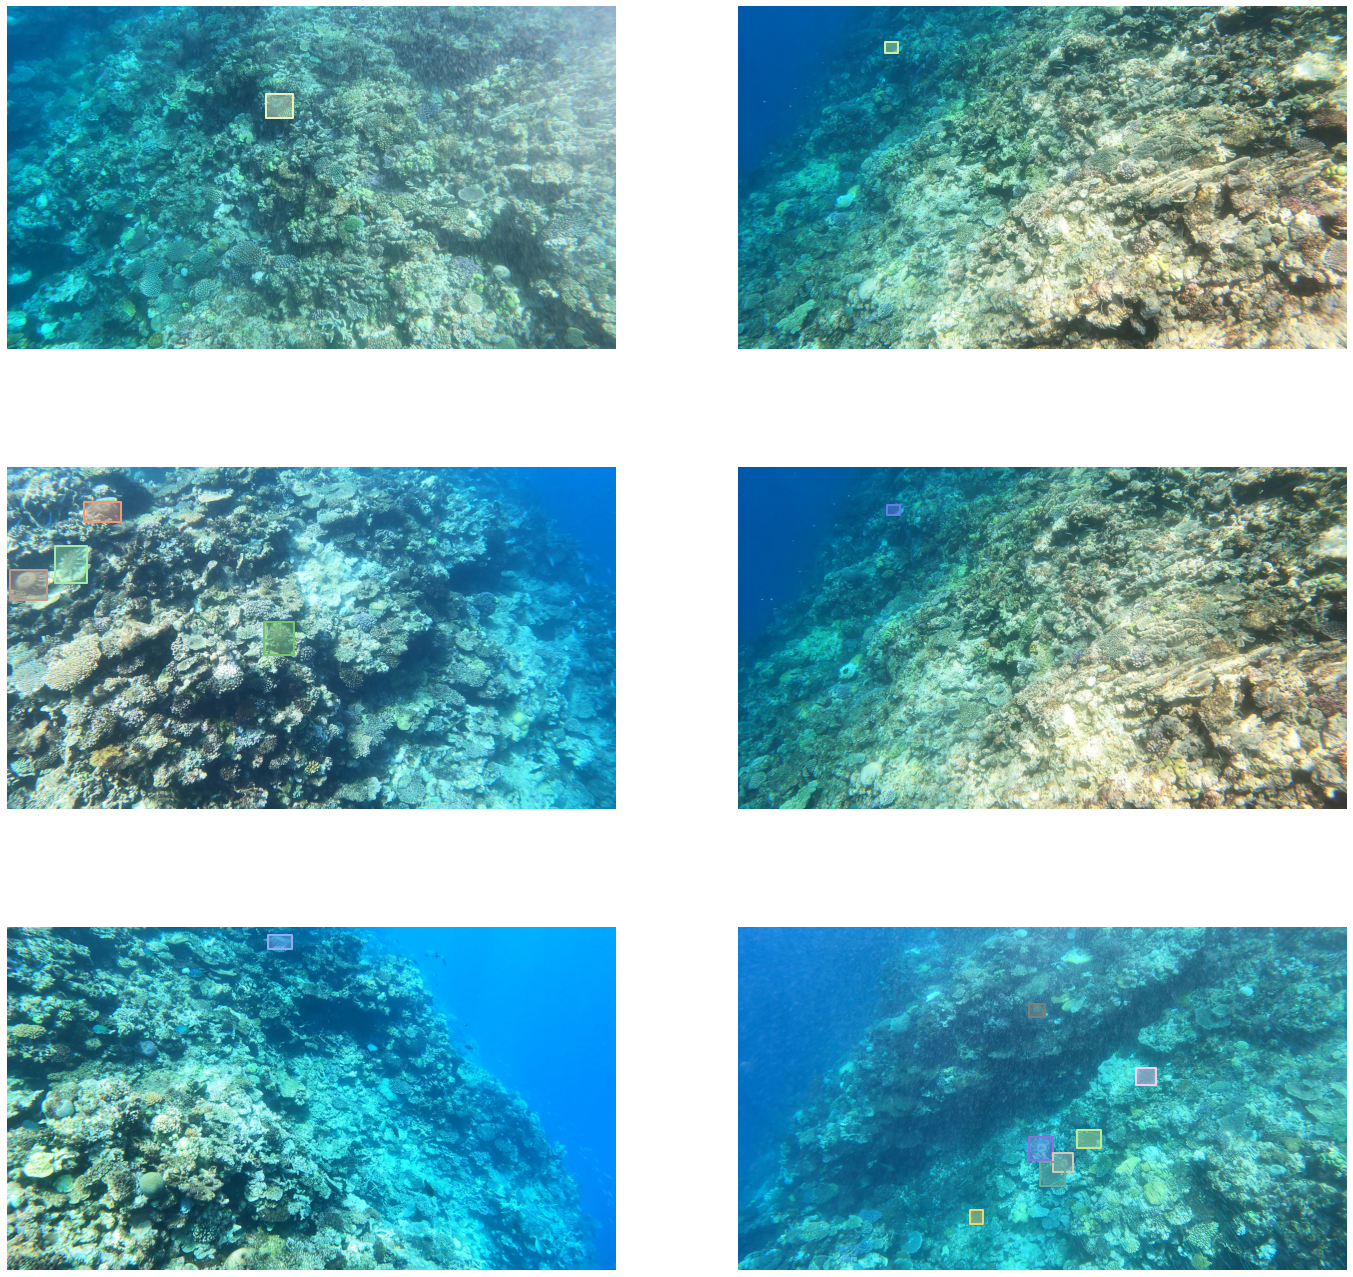

In [15]:
n_row = 3
n_col = 2
imgs = coco.loadImgs(sample(img_ids, n_row * n_col))
_, axs = plt.subplots(n_row, n_col, figsize=(12 * n_col, 8 * n_row))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    img_img = Image.open(f"{data_dir}/{img['file_name']}")
    anns = coco.loadAnns(coco.getAnnIds(imgIds=[img['id']]))
    ax.imshow(img_img)
    plt.sca(ax)
    coco.showAnns(anns, draw_bbox=True)
    plt.axis('off')
plt.show()

# Config

In [16]:
from pathlib import Path

In [19]:
%%writefile ../mmdetection/configs/COTS/train_sample.py

# The new config inherits a base config to highlight the necessary modification
_base_ = '../../configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'

# We also need to change the num_classes in head to match the dataset's annotation
model = dict(
    roi_head=dict(
        bbox_head=dict(num_classes=1),
        mask_head=dict(type='FCNMaskHead', 
                       num_convs=0, 
                       in_channels=256, 
                       conv_out_channels=256, 
                       num_classes=1, 
                       loss_mask=dict(type='CrossEntropyLoss', 
                                      use_mask=True, 
                                      loss_weight=1.0
                                     )
                      )
    )
)

# Modify dataset related settings
dataset_type = 'COCODataset'
classes = ('cots',)
data = dict(
    train=dict(
        img_prefix='/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/images/',
        classes=classes,
        ann_file='/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/annotations_train.json'),
    val=dict(
        img_prefix='/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/images/',
        classes=classes,
        ann_file='/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/annotations_valid.json'),
    test=dict(
        img_prefix='/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/images/',
        classes=classes,
        ann_file='/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/annotations_valid.json')
    
)

# We can use the pre-trained Mask RCNN model to obtain higher performance
load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
#load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

Overwriting ../mmdetection/configs/COTS/train_sample.py


In [20]:
%%writefile ../mmdetection/configs/swin/TFGBR_swin_base_faster_rcnn_fp16.py

_base_ = [
    '../_base_/models/cascade_rcnn_r50_fpn.py',
    '../_base_/datasets/coco_detection.py',
    '../_base_/schedules/schedule_1x.py', '../_base_/default_runtime.py'
]
pretrained = 'https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_small_patch4_window7_224.pth'
model = dict(
    backbone=dict(
        _delete_=True,
        type='SwinTransformer',
        embed_dims=96,
        depths=[2, 2, 18, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.,
        attn_drop_rate=0.,
        drop_path_rate=0.3,
        patch_norm=True,
        out_indices=(0, 1, 2, 3),
        with_cp=False,
        convert_weights=True,
        init_cfg=dict(type='Pretrained', checkpoint=pretrained)),
    neck=dict(in_channels=[96, 192, 384, 768]),
    roi_head=dict(
        type='CascadeRoIHead',
        num_stages=3,
        stage_loss_weights=[1, 0.5, 0.25],
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head=[
            dict(
                type='Shared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=1,
                bbox_coder=dict(
                    type='DeltaXYWHBBoxCoder',
                    target_means=[0., 0., 0., 0.],
                    target_stds=[0.1, 0.1, 0.2, 0.2]),
                reg_class_agnostic=True,
                loss_cls=dict(
                    type='CrossEntropyLoss',
                    use_sigmoid=False,
                    loss_weight=1.0),
                reg_decoded_bbox=True,
                loss_bbox=dict(type='GIoULoss', loss_weight=10.0)),
            dict(
                type='Shared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=1,
                bbox_coder=dict(
                    type='DeltaXYWHBBoxCoder',
                    target_means=[0., 0., 0., 0.],
                    target_stds=[0.05, 0.05, 0.1, 0.1]),
                reg_class_agnostic=True,
                loss_cls=dict(
                    type='CrossEntropyLoss',
                    use_sigmoid=False,
                    loss_weight=1.0),
                reg_decoded_bbox=True,
                loss_bbox=dict(type='GIoULoss', loss_weight=10.0)),
            dict(
                type='Shared2FCBBoxHead',
                in_channels=256,
                fc_out_channels=1024,
                roi_feat_size=7,
                num_classes=1,
                bbox_coder=dict(
                    type='DeltaXYWHBBoxCoder',
                    target_means=[0., 0., 0., 0.],
                    target_stds=[0.033, 0.033, 0.067, 0.067]),
                reg_class_agnostic=True,
                loss_cls=dict(
                    type='CrossEntropyLoss',
                    use_sigmoid=False,
                    loss_weight=1.0),
                reg_decoded_bbox=True,
                loss_bbox=dict(type='GIoULoss', loss_weight=10.0))
        ]))

optimizer = dict(
    _delete_=True,
    type='AdamW',
    lr=0.0004,
    betas=(0.9, 0.999),
    weight_decay=0.05,
    paramwise_cfg=dict(
        custom_keys={
            'absolute_pos_embed': dict(decay_mult=0.),
            'relative_position_bias_table': dict(decay_mult=0.),
            'norm': dict(decay_mult=0.)
        }))
lr_config = dict(warmup_iters=500, step=[8, 11])
runner = dict(max_epochs=14)

Overwriting ../mmdetection/configs/swin/TFGBR_swin_base_faster_rcnn_fp16.py


In [21]:
from mmcv import Config
cfg = Config.fromfile('../mmdetection/configs/swin/TFGBR_swin_base_faster_rcnn_fp16.py')

In [22]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile',to_float32=True),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='AutoAugment',
        policies=[[
            dict(
                type='Resize',
                img_scale=[(480, 1333), (512, 1333), (544, 1333), (576, 1333),
                           (608, 1333), (640, 1333), (672, 1333), (704, 1333),
                           (736, 1333), (768, 1333), (800, 1333)],
                multiscale_mode='value',
                keep_ratio=True)
        ],
                  [
                      dict(
                          type='Resize',
                          img_scale=[(400, 1333), (500, 1333), (600, 1333)],
                          multiscale_mode='value',
                          keep_ratio=True),
                      dict(
                          type='RandomCrop',
                          crop_type='absolute_range',
                          crop_size=(384, 600),
                          allow_negative_crop=True),
                      dict(
                          type='Resize',
                          img_scale=[(480, 1333), (512, 1333), (544, 1333),
                                     (576, 1333), (608, 1333), (640, 1333),
                                     (672, 1333), (704, 1333), (736, 1333),
                                     (768, 1333), (800, 1333)],
                          multiscale_mode='value',
                          override=True,
                          keep_ratio=True),
                      dict(
                            type='PhotoMetricDistortion',
                            brightness_delta=32,
                            contrast_range=(0.5, 1.5),
                            saturation_range=(0.5, 1.5),
                            hue_delta=18),
                    dict(
                            type='MinIoURandomCrop',
                            min_ious=(0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
                            min_crop_size=0.3),
                    dict(
                            type='CutOut',
                            n_holes=(5, 10),
                            cutout_shape=[(4, 4), (4, 8), (8, 4), (8, 8),
                                          (16, 32), (32, 16), (32, 32),
                                          (32, 48), (48, 32), (48, 48)]
                            )
                  ]]),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]

test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img'])
        ])
]

In [30]:
cfg.classes = ('cots',)
cfg.work_dir = './model_output'
cfg.data_root = '/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/'

# for head in cfg.model.roi_head.bbox_head:
#     head.num_classes = 1

cfg.data.train.type = 'CocoDataset'
cfg.data.train.classes = ('cots',)
cfg.data.train.ann_file = cfg.data_root + 'annotations_train.json'
cfg.data.train.img_prefix = cfg.data_root + 'images/'

cfg.data.test.type = 'CocoDataset'
cfg.data.test.classes = ('cots',)
cfg.data.test.ann_file = cfg.data_root + 'annotations_valid.json'
cfg.data.test.img_prefix = cfg.data_root + 'images/'


cfg.data.val.type = 'CocoDataset'
cfg.data.val.classes = ('cots',)
cfg.data.val.ann_file = cfg.data_root + 'annotations_valid.json'
cfg.data.val.img_prefix = cfg.data_root + 'images/'

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu = 2

cfg.train_pipeline = train_pipeline
cfg.val_pipeline = test_pipeline
cfg.test_pipeline = test_pipeline

cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.val.pipeline = cfg.val_pipeline
cfg.data.test.pipeline = cfg.test_pipeline 

cfg.lr_config = dict(
    policy='CosineAnnealing', 
    by_epoch=False,
    warmup='linear', 
    warmup_iters= 1000, 
    warmup_ratio= 1/10,
    min_lr=1e-07)

cfg.evaluation.interval = 2
cfg.evaluation.save_best='auto'

cfg.seed = 2022
cfg.gpu_ids = range(1)

cfg.fp16 = dict(loss_scale=dict(init_scale=512.))

cfg.log_config = dict(
    interval=100,
    hooks=[
        dict(type='TextLoggerHook'),
        dict(type='TensorboardLoggerHook')
    ])

meta = dict()
meta['config'] = cfg.pretty_text

In [24]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.apis import inference_detector

In [25]:
datasets = [build_dataset(cfg.data.train)]
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.init_weights()
model.CLASSES = datasets[0].CLASSES

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2022-01-16 22:32:32,658 - mmdet - INFO - load checkpoint from http path: https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_small_patch4_window7_224.pth
2022-01-16 22:32:32,801 - mmdet - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-01-16 22:32:32,812 - mmdet - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2022-01-16 22:32:32,817 - mmdet - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'distribution': 'uniform', 'override': [{'name': 'shared_fcs'}, {'name': 'cls_fcs'}, {'name': 'reg_fcs'}]}]
2022-01-16 22:32:32,893 - mmdet - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type

2022-01-16 22:32:33,071 - mmcv - INFO - 
backbone.stages.1.blocks.0.attn.w_msa.proj.bias - torch.Size([192]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,071 - mmcv - INFO - 
backbone.stages.1.blocks.0.norm2.weight - torch.Size([192]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,072 - mmcv - INFO - 
backbone.stages.1.blocks.0.norm2.bias - torch.Size([192]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,072 - mmcv - INFO - 
backbone.stages.1.blocks.0.ffn.layers.0.0.weight - torch.Size([768, 192]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,072 - mmcv - INFO - 
backbone.stages.1.blocks.0.ffn.layers.0.0.bias - torch.Size([768]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,073 - mmcv - INFO - 
backbone.stages.1.blocks.0.ffn.layers.1.weight - torch.Size([192, 768]): 
Initialized b

2022-01-16 22:32:33,086 - mmcv - INFO - 
backbone.stages.2.blocks.1.ffn.layers.1.weight - torch.Size([384, 1536]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,087 - mmcv - INFO - 
backbone.stages.2.blocks.1.ffn.layers.1.bias - torch.Size([384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,087 - mmcv - INFO - 
backbone.stages.2.blocks.2.norm1.weight - torch.Size([384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,087 - mmcv - INFO - 
backbone.stages.2.blocks.2.norm1.bias - torch.Size([384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,087 - mmcv - INFO - 
backbone.stages.2.blocks.2.attn.w_msa.relative_position_bias_table - torch.Size([169, 12]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,088 - mmcv - INFO - 
backbone.stages.2.blocks.2.attn.w_msa.qkv.weight - torch.Size([1152

2022-01-16 22:32:33,097 - mmcv - INFO - 
backbone.stages.2.blocks.5.attn.w_msa.proj.bias - torch.Size([384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,097 - mmcv - INFO - 
backbone.stages.2.blocks.5.norm2.weight - torch.Size([384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,097 - mmcv - INFO - 
backbone.stages.2.blocks.5.norm2.bias - torch.Size([384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,097 - mmcv - INFO - 
backbone.stages.2.blocks.5.ffn.layers.0.0.weight - torch.Size([1536, 384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,098 - mmcv - INFO - 
backbone.stages.2.blocks.5.ffn.layers.0.0.bias - torch.Size([1536]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,098 - mmcv - INFO - 
backbone.stages.2.blocks.5.ffn.layers.1.weight - torch.Size([384, 1536]): 
Initialize

2022-01-16 22:32:33,107 - mmcv - INFO - 
backbone.stages.2.blocks.9.norm1.bias - torch.Size([384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,107 - mmcv - INFO - 
backbone.stages.2.blocks.9.attn.w_msa.relative_position_bias_table - torch.Size([169, 12]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,107 - mmcv - INFO - 
backbone.stages.2.blocks.9.attn.w_msa.qkv.weight - torch.Size([1152, 384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,108 - mmcv - INFO - 
backbone.stages.2.blocks.9.attn.w_msa.qkv.bias - torch.Size([1152]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,108 - mmcv - INFO - 
backbone.stages.2.blocks.9.attn.w_msa.proj.weight - torch.Size([384, 384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,108 - mmcv - INFO - 
backbone.stages.2.blocks.9.attn.w_msa.proj.bias

2022-01-16 22:32:33,117 - mmcv - INFO - 
backbone.stages.2.blocks.12.norm2.bias - torch.Size([384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,117 - mmcv - INFO - 
backbone.stages.2.blocks.12.ffn.layers.0.0.weight - torch.Size([1536, 384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,117 - mmcv - INFO - 
backbone.stages.2.blocks.12.ffn.layers.0.0.bias - torch.Size([1536]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,118 - mmcv - INFO - 
backbone.stages.2.blocks.12.ffn.layers.1.weight - torch.Size([384, 1536]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,118 - mmcv - INFO - 
backbone.stages.2.blocks.12.ffn.layers.1.bias - torch.Size([384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,118 - mmcv - INFO - 
backbone.stages.2.blocks.13.norm1.weight - torch.Size([384]): 
Initial

2022-01-16 22:32:33,138 - mmcv - INFO - 
backbone.stages.2.blocks.16.attn.w_msa.relative_position_bias_table - torch.Size([169, 12]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,138 - mmcv - INFO - 
backbone.stages.2.blocks.16.attn.w_msa.qkv.weight - torch.Size([1152, 384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,138 - mmcv - INFO - 
backbone.stages.2.blocks.16.attn.w_msa.qkv.bias - torch.Size([1152]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,139 - mmcv - INFO - 
backbone.stages.2.blocks.16.attn.w_msa.proj.weight - torch.Size([384, 384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,139 - mmcv - INFO - 
backbone.stages.2.blocks.16.attn.w_msa.proj.bias - torch.Size([384]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,139 - mmcv - INFO - 
backbone.stages.2.blocks.16.norm

2022-01-16 22:32:33,148 - mmcv - INFO - 
backbone.stages.3.blocks.1.attn.w_msa.proj.bias - torch.Size([768]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,148 - mmcv - INFO - 
backbone.stages.3.blocks.1.norm2.weight - torch.Size([768]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,148 - mmcv - INFO - 
backbone.stages.3.blocks.1.norm2.bias - torch.Size([768]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,148 - mmcv - INFO - 
backbone.stages.3.blocks.1.ffn.layers.0.0.weight - torch.Size([3072, 768]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,149 - mmcv - INFO - 
backbone.stages.3.blocks.1.ffn.layers.0.0.bias - torch.Size([3072]): 
Initialized by user-defined `init_weights` in SwinTransformer  
 
2022-01-16 22:32:33,149 - mmcv - INFO - 
backbone.stages.3.blocks.1.ffn.layers.1.weight - torch.Size([768, 3072]): 
Initialize

2022-01-16 22:32:33,159 - mmcv - INFO - 
roi_head.bbox_head.1.shared_fcs.1.bias - torch.Size([1024]): 
XavierInit: gain=1, distribution=uniform, bias=0 
 
2022-01-16 22:32:33,159 - mmcv - INFO - 
roi_head.bbox_head.2.fc_cls.weight - torch.Size([2, 1024]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2022-01-16 22:32:33,159 - mmcv - INFO - 
roi_head.bbox_head.2.fc_cls.bias - torch.Size([2]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2022-01-16 22:32:33,160 - mmcv - INFO - 
roi_head.bbox_head.2.fc_reg.weight - torch.Size([4, 1024]): 
NormalInit: mean=0, std=0.001, bias=0 
 
2022-01-16 22:32:33,160 - mmcv - INFO - 
roi_head.bbox_head.2.fc_reg.bias - torch.Size([4]): 
NormalInit: mean=0, std=0.001, bias=0 
 
2022-01-16 22:32:33,160 - mmcv - INFO - 
roi_head.bbox_head.2.shared_fcs.0.weight - torch.Size([1024, 12544]): 
XavierInit: gain=1, distribution=uniform, bias=0 
 
2022-01-16 22:32:33,160 - mmcv - INFO - 
roi_head.bbox_head.2.shared_fcs.0.bias - torch.Size([1024]): 
XavierInit: gain=1, dist

In [27]:
import os
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))

In [31]:
train_detector(model, datasets, cfg, distributed=False, validate=True, meta = meta)

2022-01-16 22:33:45,151 - mmdet - INFO - Start running, host: vincent@vincent-station, work_dir: /home/vincent/Kaggle/Kaggle_TGBR/notebook/model_output
2022-01-16 22:33:45,152 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) CosineAnnealingLrUpdaterHook       
(ABOVE_NORMAL) Fp16OptimizerHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) CosineAnnealingLrUpdaterHook       
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
 -------------------- 
before_train_iter:
(VERY_HIGH   ) CosineAnnealingLrUpdaterHook       


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2022-01-16 22:34:23,541 - mmdet - INFO - Epoch [1][100/1968]	lr: 7.564e-05, eta: 2:55:36, time: 0.384, data_time: 0.024, memory: 8746, loss_rpn_cls: 0.1742, loss_rpn_bbox: 0.0163, s0.loss_cls: 0.0652, s0.acc: 98.3170, s0.loss_bbox: 0.0242, s1.loss_cls: 0.0239, s1.acc: 98.9081, s1.loss_bbox: 0.0033, s2.loss_cls: 0.0122, s2.acc: 98.5663, s2.loss_bbox: 0.0004, loss: 0.3197
2022-01-16 22:35:00,008 - mmdet - INFO - Epoch [1][200/1968]	lr: 1.116e-04, eta: 2:50:36, time: 0.365, data_time: 0.003, memory: 8746, loss_rpn_cls: 0.0860, loss_rpn_bbox: 0.0149, s0.loss_cls: 0.1305, s0.acc: 96.6768, s0.loss_bbox: 0.1223, s1.loss_cls: 0.0396, s1.acc: 98.3086, s1.loss_bbox: 0.0211, s2.loss_cls: 0.0118, s2.acc: 99.1602, s2.loss_bbox: 0.0024, loss: 0.4287
2022-01-16 22:35:38,148 - mmdet - INFO - Epoch [1][300/1968]	lr: 1.476e-04, eta: 2:51:03, time: 0.381, data_time: 0.003, memory: 9066, loss_rpn_cls: 0.0604, loss_rpn_bbox: 0.0146, s0.loss_cls: 0.1095, s0.acc: 96.7227, s0.loss_bbox: 0.1255, s1.loss_cls: 0

RuntimeError: CUDA out of memory. Tried to allocate 46.00 MiB (GPU 0; 10.76 GiB total capacity; 9.45 GiB already allocated; 13.62 MiB free; 9.80 GiB reserved in total by PyTorch)